## Stardist training example

In [1]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from pathlib import Path
import json

## Check what devices we have access to....

Not as important to have a beefy GPU for 2D as it is for 3D, but let's check

In [2]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is simply because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [3]:

#tnia_images_path = Path(r'/home/bnorthan/images')
tnia_images_path = Path("D:/images")
parent_path=Path(tnia_images_path / r'tnia-python-images\imagesc\2024_08_19_Dapi_CJ')
#test_name='bsp1-2.jpg'
n_rays = 32

train_path = parent_path / 'patches'

with open(train_path / 'info.json', 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data['sub_sample']
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

image_patch_path = train_path / 'ground truth0'
label_patch_path = train_path / 'input0'

model_path = parent_path / 'model'

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

sub_sample 1
axes YX


## Use a helper to collect the training data

The helper will also optionally normalize the inputs.

Normalization is a tricky issue sometimes it makes sense to normalize before creating patches, such that the data is normalized based on statistics of a larger region, closer to the normalization range that will be used for prediction. 

In [4]:
from tnia.deeplearning.dl_helper import collect_training_data
add_trivial_channel = False

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel = add_trivial_channel)

print('type X ', type(X))
print('type Y ', type(Y))

type X  <class 'list'>
type Y  <class 'list'>


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

(256, 256) (256, 256)
0.09842558 1.0


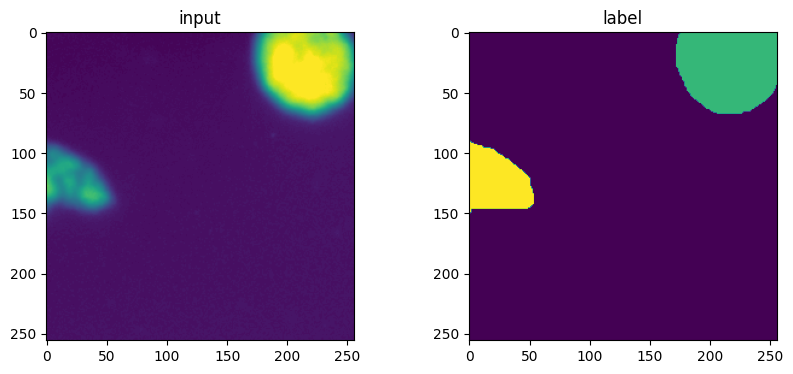

In [5]:
n=35
print(X[n].shape, Y[n].shape)
print(X[n].min(), X[n].max())
fig=imshow_multi2d([X[n], Y[n]], ['input', 'label'], 1,2)

In [6]:
from tnia.deeplearning.dl_helper import divide_training_data

X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, val_size=2)

print('type X_train ', type(X_train))

type X_train  <class 'numpy.ndarray'>


In [7]:
Y_train.dtype, Y_train.max()

test = Y_train.astype('int16')
test.dtype, test.min(), test.max()

Y_train = Y_train.astype('int16')
Y_val = Y_val.astype('int16')

## Create stardist model

In this cell we create the model.  Make sure to rename the model and give it a descriptive name that conveys the training data and setting used. 

In [8]:
from stardist.models import StarDist2D, Config2D
from tnia.deeplearning.dl_helper import augmenter

if axes == 'YXC':
    n_channel_in =3
else:
    n_channel_in = 1

model_name = "model2"
new_model = True 

if new_model:

    config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (256,256), unet_n_depth=3)
    model = StarDist2D(config=config, name=model_name, basedir=model_path)
else:
    model = StarDist2D(config=None, name=model_name, basedir=model_path)

base_model.py (198): output path for model already exists, files may be overwritten: D:\images\tnia-python-images\imagesc\2024_08_19_Dapi_CJ\model\model2


Using default values: prob_thresh=0.5, nms_thresh=0.4.


## Train the model

In [9]:
X_val.shape, Y_val.shape

((2, 256, 256), (2, 256, 256))

In [10]:
X_train.shape, Y_train.shape

((384, 256, 256), (384, 256, 256))

In [11]:
#model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=100, steps_per_epoch=200, augmenter=augmenter) 
model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=100, steps_per_epoch=100) 

Epoch 1/100
100/100 [==============================] - 29s 221ms/step - loss: 3.9041 - prob_loss: 0.3928 - dist_loss: 17.5564 - prob_kld: 0.3257 - dist_relevant_mae: 17.5557 - dist_relevant_mse: 626.8655 - dist_dist_iou_metric: 0.1972 - val_loss: 3.9213 - val_prob_loss: 0.3407 - val_dist_loss: 17.9032 - val_prob_kld: 0.2628 - val_dist_relevant_mae: 17.9023 - val_dist_relevant_mse: 702.8051 - val_dist_dist_iou_metric: 0.2451 - lr: 3.0000e-04
Epoch 2/100
100/100 [==============================] - 20s 199ms/step - loss: 3.3442 - prob_loss: 0.3101 - dist_loss: 15.1704 - prob_kld: 0.2478 - dist_relevant_mae: 15.1693 - dist_relevant_mse: 491.8810 - dist_dist_iou_metric: 0.2782 - val_loss: 3.5961 - val_prob_loss: 0.3285 - val_dist_loss: 16.3380 - val_prob_kld: 0.2505 - val_dist_relevant_mae: 16.3367 - val_dist_relevant_mse: 554.5004 - val_dist_dist_iou_metric: 0.3054 - lr: 3.0000e-04
Epoch 3/100
100/100 [==============================] - 20s 198ms/step - loss: 2.8476 - prob_loss: 0.2254 - dis

KeyboardInterrupt: 

In [1]:
model.optimize_thresholds(X_val, Y_val)

NameError: name 'model' is not defined

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

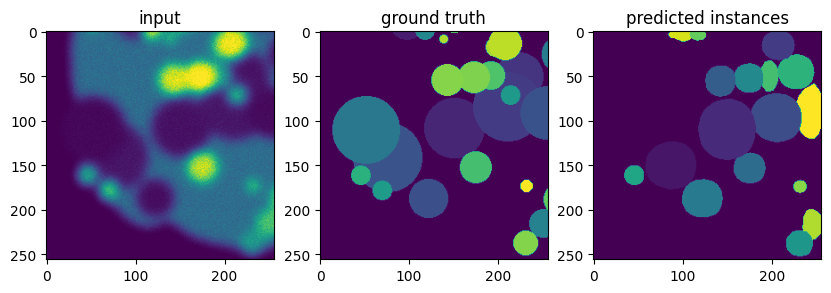

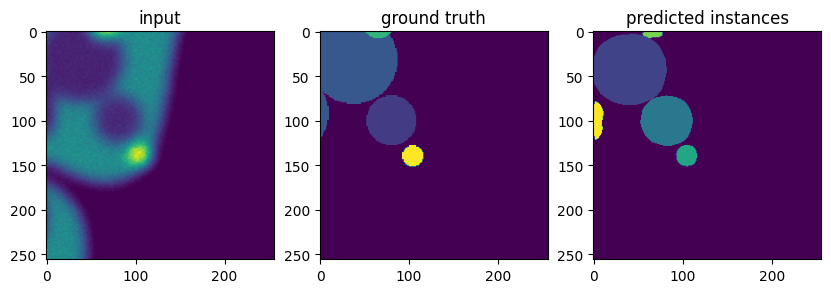

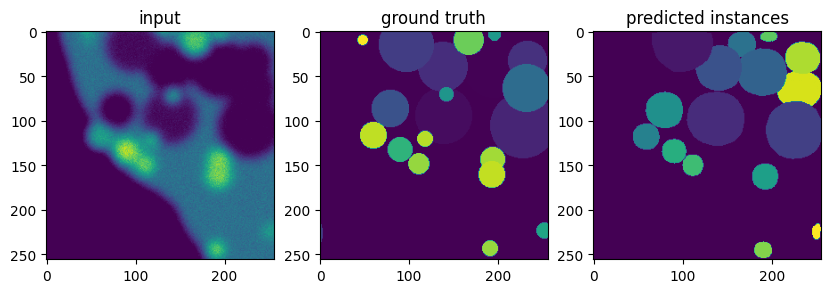

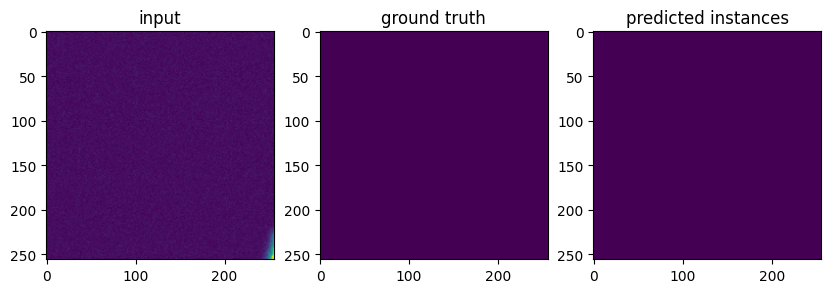

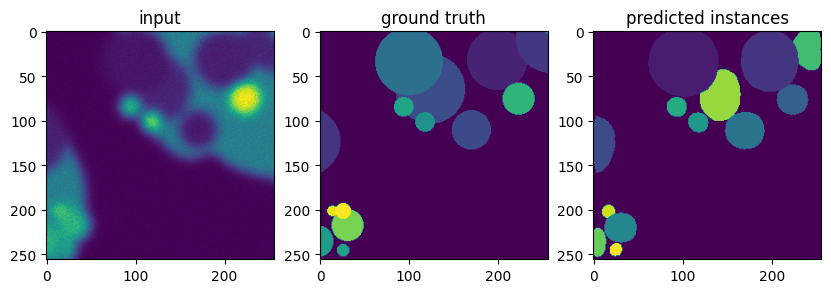

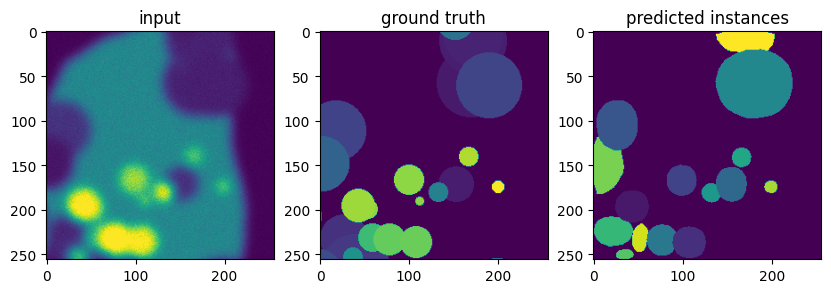

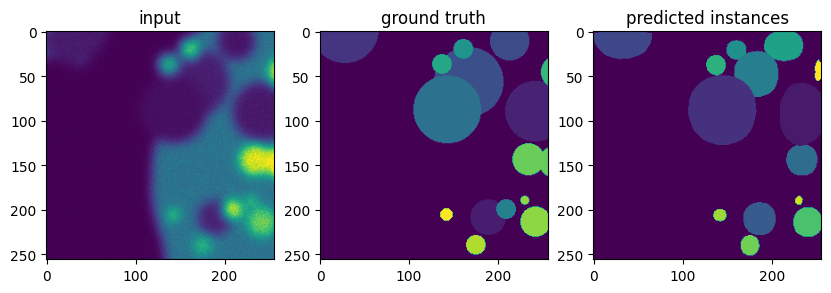

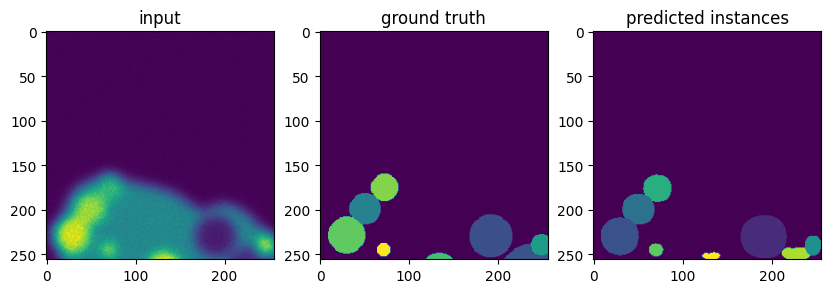

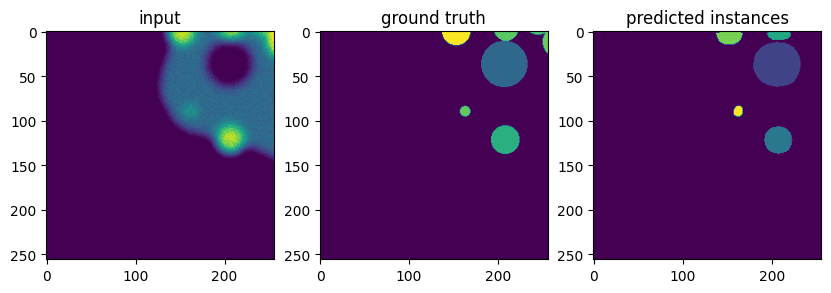

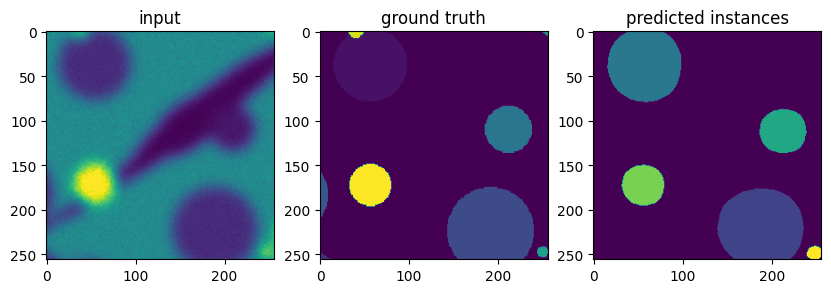

In [ ]:
for n in range(10):
    labels, details = model.predict_instances(X_train[n], prob_thresh=0.5, nms_thresh=0.9)
    fig = imshow_multi2d([X_train[n],Y_train[n],labels],['input','ground truth','predicted instances'],1,3)


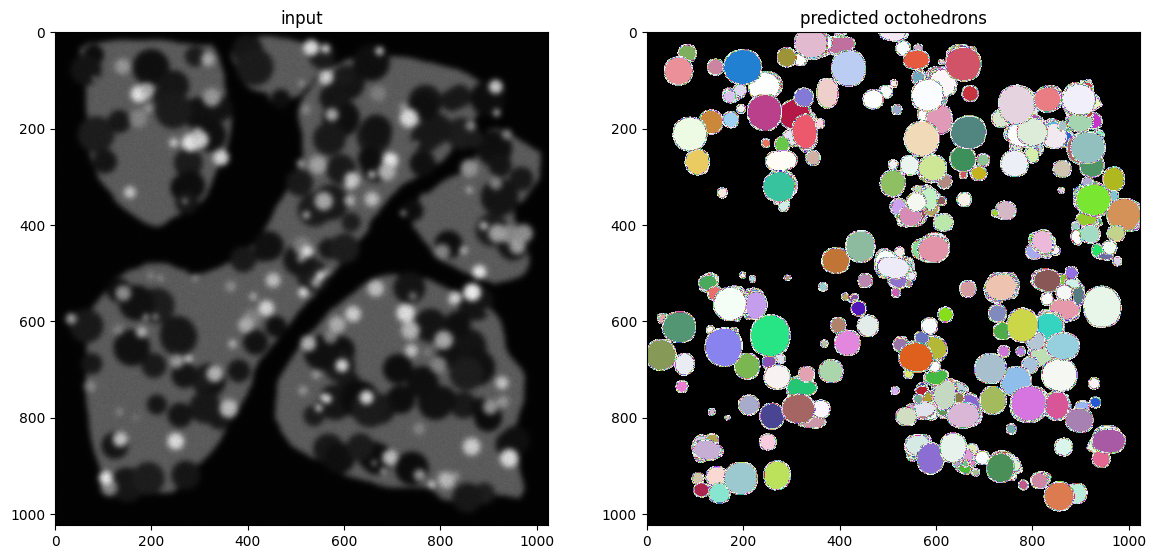

In [19]:
from skimage.io import imread
from tnia.plotting.plt_helper import random_label_cmap
from tnia.deeplearning.dl_helper import ray4_to_ellipsoid2d_labels
from csbdeep.utils import normalize
import numpy as np
test_name='phantom_1.tif'
testim = imread(parent_path  / test_name) 
if (sub_sample != 1):
    testim = testim[::sub_sample,::sub_sample]  
testim = normalize(testim,1,99.8, axis=(0,1))
labels, details = model.predict_instances(testim, prob_thresh=0.5, nms_thresh=0.9)

if n_rays == 4:
    labels2 = np.zeros_like(labels)#ray4_to_ellipsoid2d_labels(details['coord'], testim.shape)
    fig = imshow_multi2d([testim,labels,labels2],['input','predicted octohedrons', 'rendered as ellipses'],1,3, width=14, height=8,colormaps=['gray', random_label_cmap(), random_label_cmap()])
else:
    fig = imshow_multi2d([testim,labels],['input','predicted octohedrons'],1,2, width=14, height=8,colormaps=['gray', random_label_cmap()])

In [20]:
import napari

viewer = napari.Viewer()
viewer.add_image(testim, name='testim')
viewer.add_labels(labels, name='labels2')

<Labels layer 'labels2' at 0x201c1ec86d0>